# Grundläggande analys och statistik

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.power import TTestIndPower
from src.analyzer import *

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["figure.dpi"] = 120
np.set_printoptions(precision=3)
pd.set_option("display.precision", 3)
plt.style.use("ggplot")

np.random.seed(42)

In [2]:
# Läsning av datasetet
df = load_data("data/health_study_dataset.csv")

analyzer = HealthAnalyzer(df)

analyzer.explore()

Data sample:
      id  age sex  height  weight  systolic_bp  cholesterol smoker  disease
696  697   54   M   179.5   103.7        151.2         5.28    Yes        0
667  668   72   M   172.1   103.4        164.3         5.93     No        0
63    64   32   F   167.0    58.9        129.5         2.81     No        0
533  534   31   M   172.1    55.7        124.8         4.73     No        1
66    67   48   M   185.2    83.0        144.6         5.46     No        1

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 


In [3]:
# Städning
analyzer.cleaning()

Saknade värde:
 id             0
age            0
sex            0
height         0
weight         0
systolic_bp    0
cholesterol    0
smoker         0
disease        0
dtype: int64
Duplicerade rader:  0


Inledande observation

- Datasetet innehåller 800 rader, 9 kolumner. Inga saknade värden eller dubbletter

- Datatyper: 
    - Numeriska kontinuerliga: height, weight, systolic_bp, cholesterol
    - Numeriska diskreta: id, age, disease
    - Kategoriska: sex, smoker

- Range och fördelning:
    - Ålder varierar mellan 18 och 90 år, med ett medelvärde på cirka 49 år
    - Längd och vikt ligger inom rimliga intervall för vuxna
    - Blodtryck och kolesterol har också sannolika värden
"""

## Beskrivande analys

In [4]:
# Beräkning av medelvärde, median, min och max för age, weight, height, systolic_bp och cholesterol.
stats = analyzer.compute_stats(["age","weight","height"])
display(stats)

,age,weight,height
mean,49.426,73.413,171.849
median,50.000,73.200,171.350
min,18.000,33.700,144.400
max,90.000,114.400,200.400


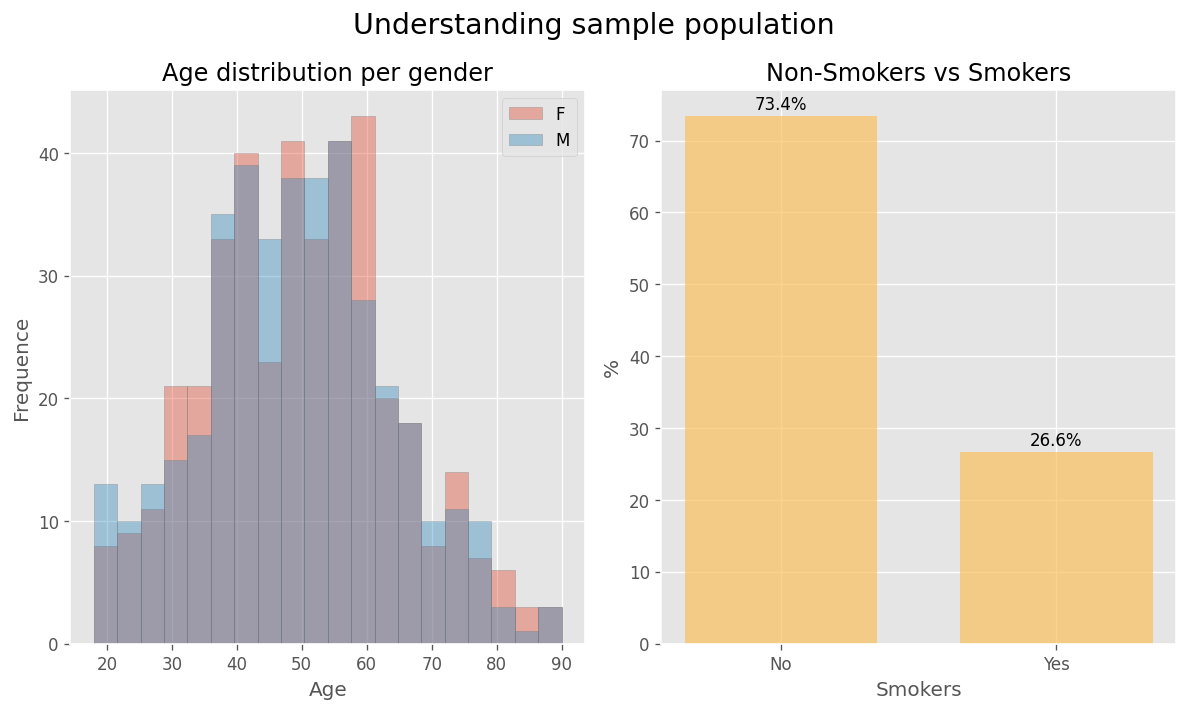

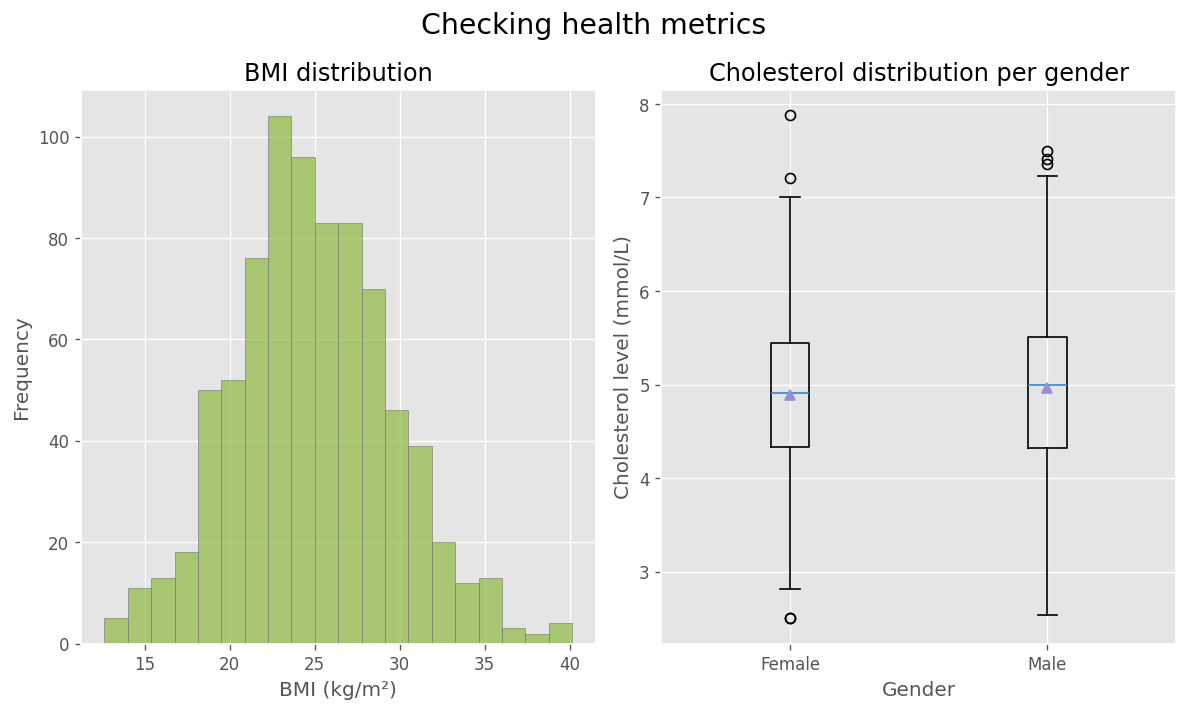

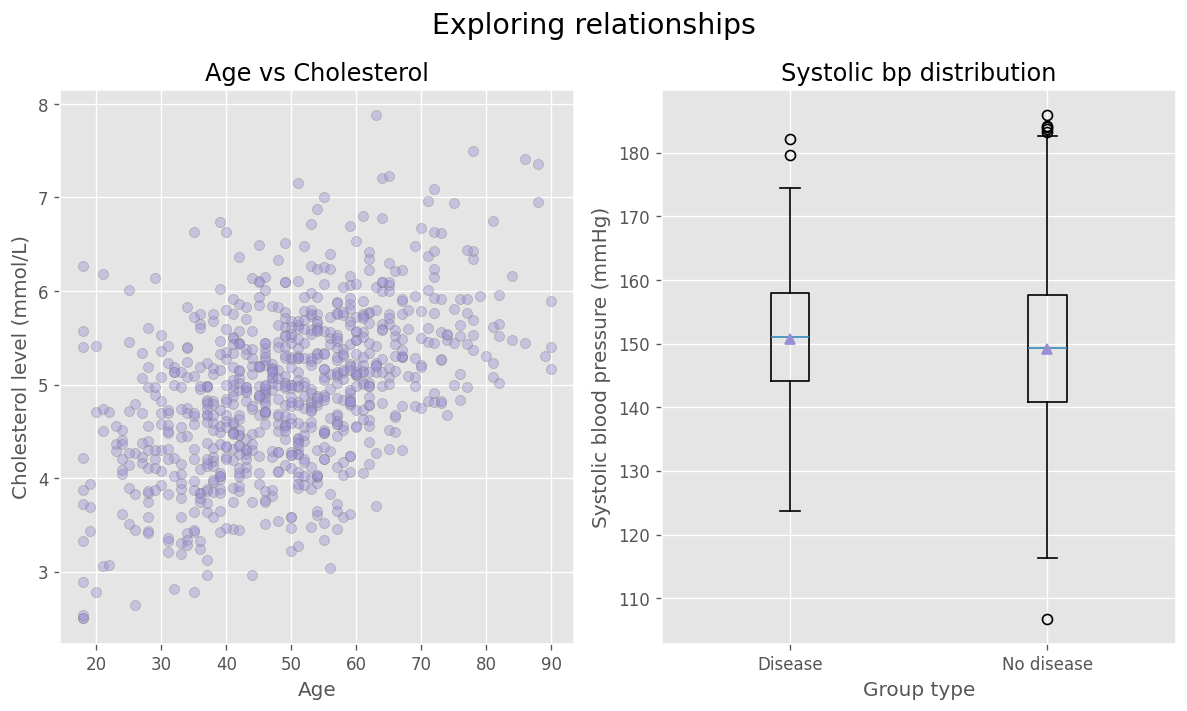

In [5]:
analyzer.plot_population_overview("img/fig1")
analyzer.plot_health_metrics("img/fig2")
analyzer.plot_relationships("img/fig3")

summary2 = """
Insikter:
1. Män och kvinnor är ganska jämnt representerade över åldersspektrumet och förekomsten av rökare är låg.
2. Normal viktintervall med få extremvärden. Liknande kolesterolnivåer mellan kvinnor och män.
3. Scatter-diagrammet visar att kolesterolnivån tenderar att öka med åldern. 
4. Det systoliska blodtrycket är liknande mellan grupper med eller utan sjukdom, vilket tyder på att det systoliska blodtrycket ensam inte kan indikera en grupp med eller utan sjukdom.
"""

## Simulering kopplad till caset

In [6]:
np.random.seed(42)
# Andelen personer i datasetet som har sjukdomen
p_disease = df["disease"].mean()

# Simulering av 1000 slumpmässiga individer med samma sjukdomsandel
simulated_1000_people = np.random.choice([0, 1], size=1000, p=[1 - p_disease, p_disease])

# Räkna andelen personer med sjukdom i simulering
simulated_p_disease = simulated_1000_people.mean()

# Jämförelse
summary3 = f"""
Verklig sjukdomsfrekvens: {p_disease * 100:.2f}%.
Simulerad sjukdomsfrekvens: {simulated_p_disease * 100:.2f}%

Slutsats:
Skillnaden mellan den verkliga sjukdomsfrekvensen och den simulerade sjukdomsfrekvensen är liten 
och ligger inom den förväntade variationen.
"""
print(summary3)


Verklig sjukdomsfrekvens: 5.88%.
Simulerad sjukdomsfrekvens: 5.60%

Slutsats:
Skillnaden mellan den verkliga sjukdomsfrekvensen och den simulerade sjukdomsfrekvensen är liten 
och ligger inom den förväntade variationen.



## Konfidensintervall

In [7]:
np.random.seed(42)
systolic_bp = np.array(df["systolic_bp"], dtype=float)
confidence = 0.95
m = np.mean(systolic_bp)
s = np.std(systolic_bp, ddof=1)
n = len(systolic_bp)
z = 1.96

# Normalapproximation
margin_error = z * (s / np.sqrt(n))
lo = m - margin_error
hi = m + margin_error

# Bootstrap
B = 3000
boot_means = np.empty(B)
for b in range(B):
    boot_sample = np.random.choice(systolic_bp, size=n, replace=True)
    boot_means[b] = np.mean(boot_sample)

alpha = (1 - confidence) / 2
bmean = np.mean(boot_means)
blo, bhi = np.percentile(boot_means, [100*alpha, 100*(1 - alpha)])

summary4 = f"""
Punktuppskattning: {m:.2f}
Standardavvikelse: {s:.2f}

Resultatet av normalapproximationen är:
Nedre 95% CI-gräns: {lo:.2f}
Övre 95% CI-gräns: {hi:.2f}

Resultatet från bootstrap är:
Medelvärde för statistiken: {bmean:.2f}
Nedre 95% CI-gräns: {blo:.2f}
Övre 95% CI-gräns: {bhi:.2f}

Slutsats:
Båda metoderna gav ett mycket liknande resultat, vilket tyder på att normalapproximationen är rimlig för detta data 
och att samplingfördelningen är nära normal.
"""
print(summary4)


Punktuppskattning: 149.18
Standardavvikelse: 12.79

Resultatet av normalapproximationen är:
Nedre 95% CI-gräns: 148.29
Övre 95% CI-gräns: 150.07

Resultatet från bootstrap är:
Medelvärde för statistiken: 149.19
Nedre 95% CI-gräns: 148.32
Övre 95% CI-gräns: 150.11

Slutsats:
Båda metoderna gav ett mycket liknande resultat, vilket tyder på att normalapproximationen är rimlig för detta data 
och att samplingfördelningen är nära normal.



FileNotFoundError: [Errno 2] No such file or directory: '../img/fig4.png'

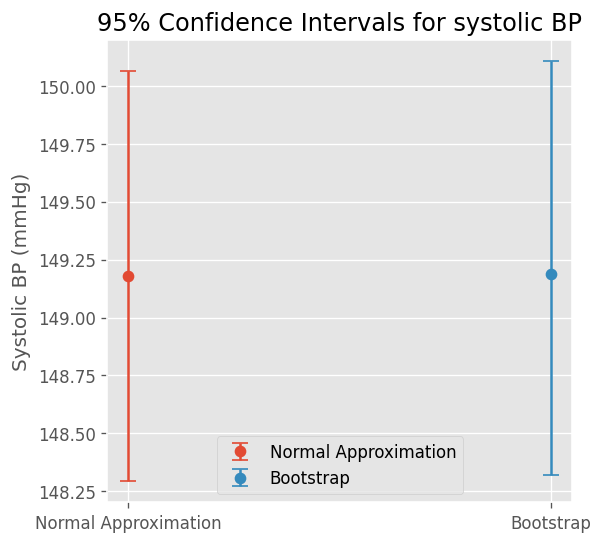

In [8]:
# Error bar: jämförelse mellan konfidensintervall beräknat med normalapproximation och med bootstrap
fig4, ax = plt.subplots(figsize=(5,5))
ax.errorbar(x=0, y=m, yerr=margin_error, fmt="o", label="Normal Approximation", capsize=5)
ax.errorbar(x=1, y=bmean, yerr=[[bmean-blo], [bhi-bmean]], fmt="o", label="Bootstrap", capsize=5)
ax.set_xticks([0,1])
ax.set_xticklabels(["Normal Approximation", "Bootstrap"])
ax.set_ylabel("Systolic BP (mmHg)")
ax.set_title("95% Confidence Intervals for systolic BP")
ax.legend()
fig4.savefig("../img/fig4")
plt.show()

## Hypotesprövning

**Hypoteser**:  
H0: Rökare och icke-rökare har samma blodtryck  
H1: Rökare har högre blodtryck än icke-rökare

In [ ]:
smokers = df.loc[df["smoker"] == "Yes", "systolic_bp"]
non_smokers = df.loc[df["smoker"] == "No", "systolic_bp"]

# Two indipendent samples, one-sided test (right tail)
t_stat, p_value = stats.ttest_ind(smokers, non_smokers, equal_var=False, alternative="greater")
smokers_mean, non_smokers_mean = smokers.mean(), non_smokers.mean()
diff_means = smokers_mean - non_smokers_mean

summary5 = f"""
Medelvärde rökare: {smokers_mean:.3f}
Medelvärde icke-rökare: {non_smokers_mean:.3f}
Skillnad mellan medelvärdena: {diff_means:.3f}

Testet gav ett t-värde på {t_stat:.3f} och ett p-värde på {p_value:.3f}.
"""
print(summary5)

**Motivering och val av test**:  

Val av test: Tvåprovstest (Welch’s t-test)
- Data är kvantitativa och de två grupperna är oberoende.
- Welch’s t-test är lämpligt eftersom grupperna har olika storlekar.
- Ensidigt test (höger svans) används eftersom vi specifikt vill testa om rökare har högre blodtryck.
- Signifikansnivå α = 0,05, vilket är standard.

**Tolkning**:
Eftersom p-värdet är större än 0,05 kan vi inte förkasta H0. Det finns inte tillräckligt med bevis för att dra slutsatsen att rökare har högre blodtryck än icke-rökare.

In [ ]:
# Violin plot: systoliskt blodtryck efter grupp rökare/icke rökare
data = [smokers, non_smokers]

fig5, ax = plt.subplots()
vp = ax.violinplot(data, showmeans=True, showmedians=True)
for body in vp["bodies"]:
    body.set_facecolor("#988ED5")
vp["cmedians"].set_color("#7A68A6")
vp["cbars"].set_color("#348ABD")
vp["cmaxes"].set_color("#348ABD")
vp["cmins"].set_color("#348ABD")
ax.set_title("Systolic BP per group")
ax.set_ylabel("Systolic BP (mmHg)")
ax.set_xticks([1, 2])
ax.set_xticklabels(["Smokers", "Non smokers"])
fig5.savefig("../img/fig5")
plt.show()

## Simulering av statistisk power

In [ ]:
# Matematisk beräkning av statistisk power 
np.random.seed(42)
alpha = 0.05
n_smokers, n_non_smokers = len(smokers), len(non_smokers)
smokers_mean, non_smokers_mean = smokers.mean(), non_smokers.mean()
ratio = n_non_smokers / n_smokers

sd_smokers, sd_non_smokers = smokers.std(), non_smokers.std()
pooled_sd = np.sqrt(((n_smokers - 1) * sd_smokers**2 + (n_non_smokers - 1) * sd_non_smokers**2) / (n_smokers + n_non_smokers - 2))

effect_size = (smokers_mean - non_smokers_mean) / pooled_sd

solver = TTestIndPower()
theoretical_power = solver.power(effect_size=effect_size, nobs1=n_smokers, ratio=ratio, alpha=alpha, alternative="larger")

# Beräkning av statistisk power genom simulering
def simulate_ttest_power(smokers_mean, non_smokers_mean, sd_smokers, sd_non_smokers, n_smokers, n_non_smokers, alpha=0.05, n_sim=5000):
    rejections = 0
    for _ in range(n_sim):
        smokers = np.random.normal(smokers_mean, sd_smokers, n_smokers)
        nonsmokers = np.random.normal(non_smokers_mean, sd_non_smokers, n_non_smokers)
        
        t_stat_sim, p_val = stats.ttest_ind(smokers, nonsmokers, equal_var=False, alternative="greater")
        
        if p_val < alpha:
            rejections += 1

    return rejections / n_sim

sim_power = simulate_ttest_power(smokers_mean, non_smokers_mean, sd_smokers, sd_non_smokers, n_smokers, n_non_smokers, alpha=alpha, n_sim=20000)

summary6= f"""
Testets styrka
Effektstorlek: {effect_size:.2f}
Teoretisk power: {theoretical_power:.2f}
Simulerad power: {sim_power:.2f}
"""
print(summary6)

In [ ]:
# Poweranalys 
power_target = 0.8
ratio = n_non_smokers / n_smokers
s_pooled = np.sqrt(((n_smokers - 1) * sd_smokers**2 + (n_non_smokers - 1) * sd_non_smokers**2) / (n_smokers + n_non_smokers - 2))

# Solve for Cohen's d needed to reach 80% power
required_d = solver.solve_power(effect_size=None, nobs1=n_smokers, ratio=ratio, alpha=alpha, power=power_target, alternative="larger")

required_mean_diff = required_d * s_pooled

summary7 = f"""
För att uppnå 80% power skulle testet kräva en medelvärdesskillnad på cirka {required_mean_diff:.2f} mmHg (Cohen's d ≈ {required_d:.2f}). 
Den observerade skillnaden (≈ {diff_means:.2f} mmHg) är mycket mindre, vilket förklarar den låga styrkan ({sim_power * 100:.1f}%). 
"""
print(summary7)

**Motivering och resultat**:  

Syftet är att uppskatta när t-testet är tillräckligt känsligt för att upptäcka en verklig effekt. Både teoretisk och simulerad styrka beräknades för att jämföra resultaten och kontrollera att simuleringen stämmer med de teoretiska förväntningarna.

Simuleringen visar att den statistiska power är mycket låg (~0,1). Detta beror på att den observerade skillnaden i medelvärde (≈ 0,47 mmHg) är liten jämfört med variationen inom grupperna (SD ≈ 13 mmHg). Resultatet tyder på att det icke-signifikanta testet reflekterar en verklig brist på meningsfull skillnad.

En power analys visar dessutom att för att uppnå 80% power skulle en skillnad på ≈ 2,55 mmHg krävas, betydligt större än den observerade. Detta bekräftar att testets låga styrka är förenlig med den lilla effekt som hittats.

**Tolkning**:
I praktiken bekräftar testet att rökstatus inte är förknippad med någon kliniskt eller statistiskt signifikant förändring av blodtrycket i detta urval.

**Källor**:  
*Konfidensintervall*:  
- https://www.youtube.com/watch?v=xjYEYBvPaSc [13/11/2025]  

Scipy-dokumentation angående *ttest_ind*:  
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html [12/11/2025]

Dokumentation från w3cub och statsmodels angående *solve_power*:  
- https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.power.ttestindpower.solve_power [12/11/2025]  
- https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestPower.solve_power.html#statsmodels.stats.power.TTestPower.solve_power [12/11/2025]